In [1]:
!pip install records boto3 psycopg2-binary pandas

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import boto3
import records
from matplotlib import style
%matplotlib inline
style.use('ggplot')

In [2]:
db_url = boto3.client('ssm').get_parameter(Name='/bikefinder/dev/db_url', WithDecryption=True)['Parameter']['Value']
db = records.Database(db_url)

In [11]:
# Date limebike started differentiating between bikes & scootscoots
db.query("select min(created) from bike_locations where provider='limebike' and raw->'attributes'->>'vehicle_type'='scooter'").export('df')

,min
0,2018-06-13T01:44:35.232774


In [5]:
# number of bikes in operaton per day per provider
bikes_in_service = db.query(
    """
    ( -- number of unique bike_ids per provider (except ofo)
      select created::date, provider, count(distinct bike_id) num_bikes
      from bike_locations
      where provider<>'ofo'
        and (provider<>'limebike' or raw->'attributes'->>'vehicle_type'='bike' or raw->'attributes'->>'vehicle_type' is null)
      group by provider, created::date
    )
    union
    ( -- max number of ofo bikes available through out the day
      with ofo as (select * from bike_locations where provider='ofo'),
        counts_per_batch as (select count(bike_id), bike_id, created::date from ofo
                             group by bike_id, created::date)
      select created, 'ofo' provider, max("count") num_bikes
      from counts_per_batch
      group by created
    )
    order by created, provider;
    """).export('df')
bikes_in_service = bikes_in_service.pivot(index='created', columns='provider', values='num_bikes')

In [6]:
bikes_in_service

provider,JUMP,limebike,mobike,ofo,spin
created,,,,,
2018-02-18,54.0,370.0,464.0,338.0,163.0
2018-02-19,57.0,385.0,470.0,337.0,177.0
2018-02-20,68.0,391.0,463.0,330.0,185.0
2018-02-21,75.0,422.0,468.0,295.0,187.0
2018-02-22,190.0,409.0,461.0,350.0,197.0
2018-02-23,123.0,399.0,453.0,343.0,204.0
2018-02-24,69.0,398.0,451.0,323.0,189.0
2018-02-25,72.0,386.0,442.0,312.0,188.0
2018-02-26,84.0,402.0,439.0,337.0,186.0


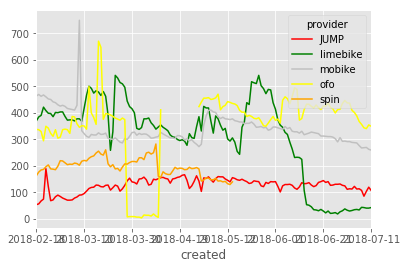

In [7]:
plt = bikes_in_service.plot()
plt.get_lines()[0].set_color('red')
plt.get_legend().get_lines()[0].set_color('red')
plt.get_lines()[1].set_color('green')
plt.get_legend().get_lines()[1].set_color('green')
plt.get_lines()[2].set_color('silver')
plt.get_legend().get_lines()[2].set_color('silver')
plt.get_lines()[3].set_color('yellow')
plt.get_legend().get_lines()[3].set_color('yellow')
plt.get_lines()[4].set_color('orange')
plt.get_legend().get_lines()[4].set_color('orange')

In [8]:
# min,avg,max lifetime of bikes per provider (except ofo, of course)
db.query(
    """
    with bike_lifetimes as (
        select bike_id, provider, max(created) - min(created) age
        from bike_locations
        where provider<>'ofo'
          and (provider<>'limebike' or raw->'attributes'->>'vehicle_type'='bike' or raw->'attributes'->>'vehicle_type' is null)
        group by bike_id, provider
    )
    select provider, min(age), avg(age), max(age)
    from bike_lifetimes
    group by provider;
    """).export('df')

,provider,min,avg,max
0,JUMP,00:00:00,102 days 23:28:58.814851,142 days 22:12:10.079721
1,mobike,00:00:03.422806,45 days 07:06:19.756071,124 days 23:52:02.937689
2,spin,00:00:00,37 days 20:43:01.574388,85 days 03:21:50.453325
3,limebike,00:00:00,30 days 05:24:04.875682,142 days 22:12:28.828350


In [ ]:
# number of bikes that have disapeared from service (haven't seen the ID in the past 3 days)
db.query(
    """
    select provider, count(bike_id)
    from bike_locations
    where provider<>'ofo'
      and (provider<>'limebike' or raw->'attributes'->>'vehicle_type'<>'scooter')
      and created < 'today'::date - '3days'::interval
      and bike_id not in (select bike_id from bike_locations where created >= 'today'::date - '3days'::interval)
    group by provider;
    """).export('df')

In [11]:
# for shits'n'giggles.. number of lime scootscoots
scoots_in_service = db.query(
    """
      select created::date, count(distinct bike_id) num_bikes, 'limescoot' provider
      from bike_locations
      where provider='limebike' and raw->'attributes'->>'vehicle_type'='scooter'
        and created > '2018-06-12'::date -- perf hack based on date above when limescoots became identifiable
      group by created::date

    order by created, provider;
    """).export('df')
scoots_in_service = scoots_in_service.pivot(index='created', columns='provider', values='num_bikes')

In [12]:
scoots_in_service

provider,limescoot
created,
2018-06-13,155
2018-06-14,130
2018-06-15,122
2018-06-16,102
2018-06-17,75
2018-06-18,71
2018-06-19,66
2018-06-20,54
2018-06-21,48


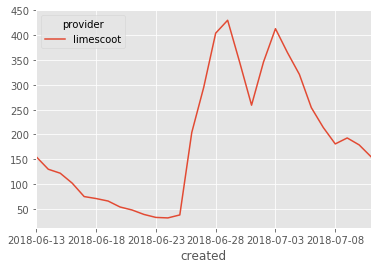

In [13]:
scoots_in_service.plot()

In [ ]:
db.close()
db._engine.dispose()